## Dual-frequency Synthetic Meta-signal Reconstruction ##
---
This notebook demonstrates the use of the **RinexTools** to reconstruct dual-frequency synthetic meta-signals. The specific case of the Galileo **AltBOC** modulation is considered.

The reconstruction function "**reconstruct_meta**" also takes into account fractional receiver biases and implements half-ambiguity resolution for the reconstructed carrier phases.

The notebook demonstrates the parsing of rinex observations, the conversion of a rinex file into a CSV file and the generation of synthetic measurements.

### Import Required Libraries ###

In [1]:
# System library
import os
import numpy as np
import pandas as pd

# Graphic library, it may requires the installation of ipympl
import matplotlib.pyplot as plt
%matplotlib widget

# Update bar
from tqdm.notebook import tqdm

# File chooser
from ipyfilechooser import FileChooser

# Custom libraries
import rinex_parser as rp

### Reconstruction Function ###

In [2]:
def reconstruct_meta(obs_block : dict, combo_info : dict ) :
    """
    Summary: 
        Function that reconstructs meta-signal observations from side-band measurements in the dual-frequency case
    
    Input:
        obs_block - block with the information from the current epoch    

        combo_info is a dictionary with the instructions to build the meta-signal

        In particular, it has the following forms
        combo_info = {
             "gnss" = "E",
             "UP" : ["Sxx", "Dxx", "Lxx", "Cxx"],   <--- C/N0, Doppler, Carrier Phase, Pseudoranges
             "DW" : ["Sxx", "Dxx", "Lxx", "Cxx"],   <--- C/N0, Doppler, Carrier Phase, Pseudoranges
             "MT" : ["Sxx", "Dxx", "Lxx", "Cxx"],   <--- C/N0, Doppler, Carrier Phase, Pseudoranges
             "lambda_sub" : val,
             "freq_up" : val,
             "freq_down" : val
            }
    
    """
    
    # Output block 
    out_block = obs_block.copy()

    # List with the potential fractional receiver biases
    recbiases = []

    if ("freq_up" in combo_info) and ("freq_down" in combo_info) :
        wup = combo_info["freq_up"] / (combo_info["freq_up"] + combo_info["freq_down"])
        wdown = combo_info["freq_down"] / (combo_info["freq_up"] + combo_info["freq_down"])
    else :
        wup = 0.5
        wdown = 0.5
    
    for ii, obs in enumerate(obs_block["obs"]) :

        # Replace or add synthetic meta-signal observations to the observation list
        # Do something only if the obs is of the correct GNSS
        if obs["gnss"] == combo_info["gnss"] :
            
            # C/N0
            if (combo_info["UP"][0] in obs) & (combo_info["DW"][0] in obs) :
                out_block["obs"][ii][combo_info["MT"][0]] = 10 * np.log10( 10**(obs[combo_info["UP"][0]] / 10) + 
                                                            10**(obs[combo_info["DW"][0]] / 10) )
            
            # Doppler
            if (combo_info["UP"][1] in obs) & (combo_info["DW"][1] in obs) :
                out_block["obs"][ii][combo_info["MT"][1]] = ( obs[combo_info["UP"][1]] + obs[combo_info["DW"][1]] ) / 2
            
            # Phase - average phase in cycles
            if (combo_info["UP"][2] in obs) & (combo_info["DW"][2] in obs) :
                out_block["obs"][ii][combo_info["MT"][2]] = ( obs[combo_info["UP"][2]] + obs[combo_info["DW"][2]] ) / 2
                
                # Subcarrier component in metres (it is equal to the widelane combination)
                subcarr = combo_info["lambda_sub"] * ( obs[combo_info["UP"][2]] - obs[combo_info["DW"][2]] ) / 2
            else :
                subcarr = 0
                # print("No carr.")
            
            # Range
            if (combo_info["UP"][3] in obs) & (combo_info["DW"][3] in obs) :
                
                # Average pseudorange - if the frequencies of the side-band components are specified, then the
                # narrow-lane combination is computed
                out_block["obs"][ii][combo_info["MT"][3]] = wup * obs[combo_info["UP"][3]] + wdown * obs[combo_info["DW"][3]] 
                
                if subcarr != 0 :
                    codeminuscarr = (out_block["obs"][ii][combo_info["MT"][3]] - subcarr) / (combo_info["lambda_sub"] / 2)
                    recbiases.append(codeminuscarr - np.floor(codeminuscarr))
                    
    # Now solve for the pseudorange ambiguities taking into account the fractional receiver bias
    rbias = np.nanmedian(recbiases)
       
    for ii, obs in enumerate(obs_block["obs"]) :
        
        if obs["gnss"] == combo_info["gnss"] :
        
            if (combo_info["UP"][2] in obs) & (combo_info["DW"][2] in obs) :
                
                # Subcarrier component in metres (it is equal to the widelane combination)
                subcarr = combo_info["lambda_sub"] * ( obs[combo_info["UP"][2]] - obs[combo_info["DW"][2]] ) / 2
                
                # Estimate the wide-lane ambiguities through the Hatch-Melburne-Wubbena combination
                wl_amb = np.round((out_block["obs"][ii][combo_info["MT"][3]] - subcarr) / (combo_info["lambda_sub"] / 2) - rbias)
                
                # Smooth the pseudoranges, rounding is done with respect to the wide-lane wavelength (lambda_sub / 2)        
                out_block["obs"][ii][combo_info["MT"][3]] = subcarr + combo_info["lambda_sub"] * wl_amb / 2
                
                # Correct carrier phases for half-carrier ambiguities
                if int(wl_amb) % 2 :
                    out_block["obs"][ii][combo_info["MT"][2]] += 0.5
                    
    return out_block

### Open the input file ###

In [3]:
fc = FileChooser()
fc

FileChooser(path='/media/daniele/5C13-0007/Projects/Development/RinexTools/code', filename='', title='', show_…

In [4]:
filename = fc.selected
print(filename)

/media/daniele/5C13-0007/Projects/Development/RinexTools/rinex/WUT000POL_R_20240680000_01H_01S_MO.rnx


### Allocate the RINEX parser ###

In [5]:
rxconv = rp.rinex_parser(filename)

### Open the output file ###

In [6]:
filename = filename.replace("\\", "/")
rxname = filename.split("/")[-1][:-4]

# Output folder
outfolder = "./rinex"
if not os.path.exists(outfolder) :
    os.mkdir(outfolder)

### Output information ###

In [9]:
# Some constant
speed_of_light = 2.99792458e8

fE5b = 1207.140e6
fE5a = 1176.45e6
fE5 = 1191.795e6

fsub = (fE5b - fE5a) / 2
lambda_sub = speed_of_light / fsub

combo_info = {
     "gnss" : "E",
     "DW" : ["S5Q", "D5Q", "L5Q", "C5Q"],   # <--- C/N0, Doppler, Carrier Phase, Pseudoranges
     "UP" : ["S7Q", "D7Q", "L7Q", "C7Q"],   # <--- C/N0, Doppler, Carrier Phase, Pseudoranges
     "MT" : ["S8Q", "D8Q", "L8Q", "C8Q"],   # <--- C/N0, Doppler, Carrier Phase, Pseudoranges
     "lambda_sub" : lambda_sub,
     "freq_up" : fE5b,
     "freq_down" : fE5a
    }

# obs_list = {"E" : ["C8Q", "L8Q", "D8Q", "S8Q"]}
obs_list = rxconv.obs_list

# Open the ouput file and add the header
rinex_file = open(outfolder + "/" + rxname + "_sAltBOC.obs", "w")

rp.add_meas_header( obs_list, rinex_file )

In [10]:
print(obs_list)

{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'S1W', 'C2W', 'L2W', 'D2W', 'S2W', 'C2L', 'L2L', 'D2L', 'S2L', 'C5Q', 'L5Q', 'D5Q', 'S5Q', 'C1L', 'L1L', 'D1L', 'S1L'], 'E': ['C1C', 'L1C', 'D1C', 'S1C', 'C6C', 'L6C', 'D6C', 'S6C', 'C5Q', 'L5Q', 'D5Q', 'S5Q', 'C7Q', 'L7Q', 'D7Q', 'S7Q', 'C8Q', 'L8Q', 'D8Q', 'S8Q'], 'C': ['C1P', 'L1P', 'D1P', 'S1P', 'C5P', 'L5P', 'D5P', 'S5P', 'C2I', 'L2I', 'D2I', 'S2I', 'C7I', 'L7I', 'D7I', 'S7I', 'C6I', 'L6I', 'D6I', 'S6I', 'C7D', 'L7D', 'D7D', 'S7D']}


### Main Processing Loop ###

In [11]:
# Just to have an idea regarding the progress operations
nobs = rxconv.get_obsnumber()

if nobs is not None :
    pbar = tqdm(total = nobs)
else :
    # Assume one day of observation
    pbar = tqdm(total = 24 * 3600)
    
obs_block = rxconv.get_obs_block()

epoch_cnt = 0

print("Processing\n")

while obs_block is not None :
    
    # Reconstruct measurements
    rec_block = reconstruct_meta(obs_block, combo_info)
    
    # Save to file
    rp.print_block(obs_list, rinex_file, rec_block)
    
    # Read a new data block
    obs_block = rxconv.get_obs_block()
            
    epoch_cnt += 1
    
    if epoch_cnt % 100 == 0 :
        pbar.update(100)
        
pbar.n = nobs
pbar.close()

  0%|          | 0/3599.0 [00:00<?, ?it/s]

Processing



In [12]:
rinex_file.close()

### Now Compare Observations the Original and Reconstructed Files ###

In [13]:
# Re-open the original RINEX file
rxconv = rp.rinex_parser(filename)

# Convert it into csv
filecsv = filename.split("/")[-1][:-4] + '.csv'

# Output folder
csvfolder = "./csv"
if not os.path.exists(csvfolder) :
    os.mkdir(csvfolder)

filecsv = csvfolder + '/' + filecsv 

rxconv.to_csv(filecsv)

# Do the same for the reconstructed file
synconv = rp.rinex_parser(outfolder + "/" + rxname + "_sAltBOC.obs")
syncsv = csvfolder + "/" + rxname + "_sAltBOC.csv"

synconv.to_csv(syncsv)

  0%|          | 0/41824864 [00:00<?, ?it/s]

  0%|          | 0/47286633 [00:00<?, ?it/s]

### Pseudorange Comparison ###

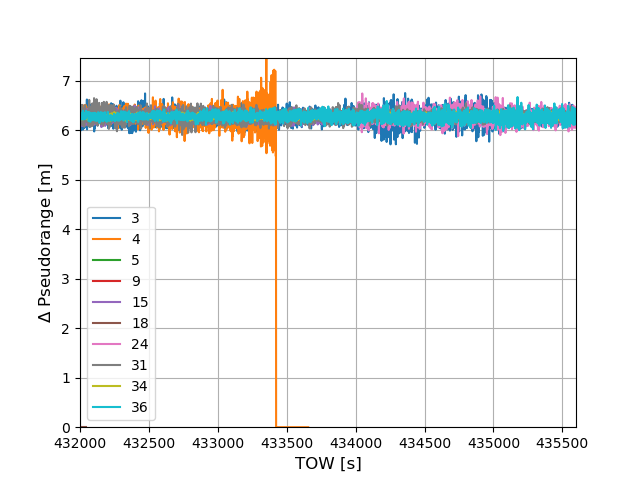

In [14]:
original_df = pd.read_csv(filecsv)
recon_df = pd.read_csv(syncsv)

# Keep only Galileo observations
original_df = original_df[original_df["GNSS"] == "E"]
recon_df = recon_df[recon_df["GNSS"] == "E"]

# list of satellites
sats = np.unique(original_df["PRN"].values)
lableg = [str(sat) for sat in sats]

fig, ax = plt.subplots()

for sat in sats :

    # Keep only pseudoranges from the specified PRN
    sat_df1 = original_df[(original_df["OBS_TYPE"].values == "C8Q") & (original_df["PRN"] == sat)]
    sat_df2 = recon_df[(recon_df["OBS_TYPE"] == "C8Q") & (recon_df["PRN"] == sat)]

    # Find common time instants
    epochs, ind1, ind2 = np.intersect1d( sat_df1["TOW"].values, sat_df2["TOW"].values, return_indices = True )

    ax.plot(epochs, sat_df1["VALUE"].iloc[ind1].values - sat_df2["VALUE"].iloc[ind2].values)
    
ax.grid(True)
ax.set_xlabel("TOW [s]", fontsize = 12)
ax.set_ylabel(r"$\Delta$ Pseudorange [m]", fontsize = 12)
ax.legend(lableg)
ax.autoscale(tight = True)

### Carrier Phase Comparison ###

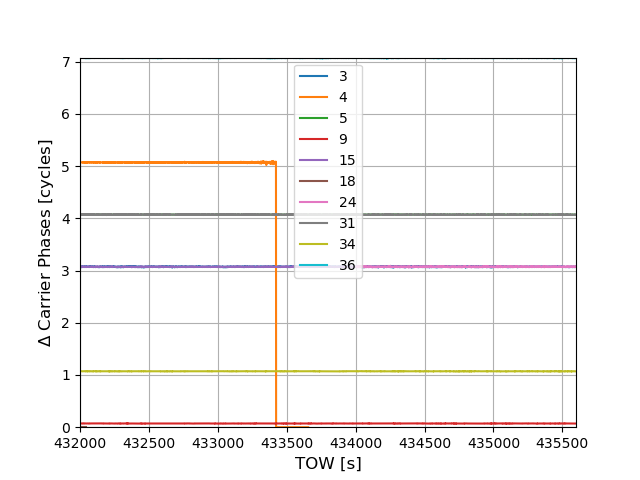

In [15]:
fig, bx = plt.subplots()

for sat in sats :
    
    # Keep only carrier phases from the specified PRN
    sat_df1 = original_df[(original_df["OBS_TYPE"].values == "L8Q") & (original_df["PRN"] == sat)]
    sat_df2 = recon_df[(recon_df["OBS_TYPE"] == "L8Q") & (recon_df["PRN"] == sat)]

    # Find common time instants
    epochs, ind1, ind2 = np.intersect1d( sat_df1["TOW"].values, sat_df2["TOW"].values, return_indices = True )

    bx.plot(epochs, sat_df1["VALUE"].iloc[ind1].values - sat_df2["VALUE"].iloc[ind2].values)
    
bx.grid(True)
bx.set_xlabel("TOW [s]", fontsize = 12)
bx.set_ylabel(r"$\Delta$ Carrier Phases [cycles]", fontsize = 12)
bx.legend(lableg)
bx.autoscale(tight = True)